# Data curation

In [2]:
!pip install pandas
!pip install matplotlib

/home/ferraz/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ferraz/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 11.5 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 33.2 MB/s eta 0:00:01
/home/ferraz/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ferraz/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |███████████████████

In [1]:
from matplotlib import pyplot as plt
from glob import glob

import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
def group(df: pd.DataFrame, name: str, col: str = 'EVOLUCAO') -> pd.DataFrame:
    aux = df.groupby(col).size().to_frame(name)
    aux = aux.rename({
        1: 'Cura',
        2: 'Óbito',
        3: 'Óbito por outras causas',
        9: 'Ignorado',
    })
    aux.index.name = 'Desfecho'
    return aux

In [3]:
def cod2age(cod: int, tp: int = None) -> int:
    '''
    if tp is None, len(str(cod)) == 4
    first digit in cod is tp, where:
      1 = hour
      2 = days
      3 = months
      4 = years
    
    if tp is not None, then:
      1 = days
      2 = months
      3 = years
    '''
    offset = 0
    _aux = str(cod)

    if tp is None:
        tp = int(_aux[0]) - 1
        offset = 1
        
    if tp == 1: # 2 = days
        return int(_aux[offset:])//365
    elif tp == 2: # 3 = months
        return int(_aux[offset:])//12
    elif tp == 3: # 4 = years
        return int(_aux[offset:])
    else:
        return 0

In [4]:
def calculate_set(sets: dict):
    """
    return dict{id: tuple('total features in id', 'unique features', 'shared features')}
    """
    result = {}
    for i in sets:
        aux = sets.copy()
        s = aux.pop(i)
        union = set()
        union = union.union(*aux.values())
        ls = len(s)
        li = len(s.intersection(union))
        result[i] = ls, ls-li, li
    return result

Função para limpeza da base
- df: dataframe de entrada
- rules: regras de substituição `{index: {'cols': colunas, 'replaces': {value: new_value}}}` p.ex:
    - `{0: {'cols': 'SEXO', 'replaces': {None:0.0}}}`

In [5]:
def clean(df: pd.DataFrame, rules: [dict]) -> pd.DataFrame:    
    for rule in rules:
        cols = rule['cols']
        df.loc[:,cols] = df.loc[:,cols].replace(rule['replaces'])
    return df

---

In [6]:
# global variables
RAW_DATA = 'datas/raw'
PROCESSED_DATA = 'datas/processed'
RESULTS = 'results'

In [7]:
files = glob(f'{RAW_DATA}/202*.csv.gz')
files.sort()
files

['datas/raw/2020.csv.gz', 'datas/raw/2021.csv.gz']

Colunas presentes em todas as bases

In [8]:
SRAG_cols = pd.DataFrame()
trows = 0
cols = set()
sets = dict()
for file in files:
    print(f'[INFO] Opening {file}')
    year = file.split('/')[-1][:-7]
    df = pd.read_csv(file, low_memory=False, compression='gzip')
    df = df[df['CLASSI_FIN']==5]
    rows = len(df)
    cols = cols.union(set(df.columns))
    trows += rows
    print(f'[INFO] {rows} rows')
    SRAG_cols = pd.concat([
        SRAG_cols,
        pd.DataFrame({col:1 for col in df.columns}, index=[year])
    ])
    sets[file] = set(df.columns)
    
print(*calculate_set(sets).items(), sep='\n')
    
print('')
print(f'[INFO] total: {trows} rows')
print(f'[INFO] total: {len(cols)} features')
SRAG_cols.to_csv(f'{RAW_DATA}/c1-SRAG_cols.csv')
SRAG_cols

[INFO] Opening datas/raw/2020.csv.gz
[INFO] 706475 rows
[INFO] Opening datas/raw/2021.csv.gz
[INFO] 1100954 rows
('datas/raw/2020.csv.gz', (154, 0, 154))
('datas/raw/2021.csv.gz', (162, 8, 154))

[INFO] total: 1807429 rows
[INFO] total: 162 features


,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV
2020,1,1,1,1,1,1,1,1,1,1,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,1,1,1,1,1,1,1,1,1,1,...,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Filtrando as colunas

In [9]:
cols_in_all = SRAG_cols.dropna(axis=1).columns
print(cols_in_all)
print(len(cols_in_all))

Index(['DT_NOTIFIC', 'SEM_NOT', 'DT_SIN_PRI', 'SEM_PRI', 'SG_UF_NOT',
       'ID_REGIONA', 'CO_REGIONA', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_UNIDADE',
       ...
       'DS_AN_OUT', 'TP_AM_SOR', 'SOR_OUT', 'DT_CO_SOR', 'TP_SOR', 'OUT_SOR',
       'DT_RES', 'RES_IGG', 'RES_IGM', 'RES_IGA'],
      dtype='object', length=154)
154


Calculando o balanceamento

In [10]:
SRAG_balance = pd.DataFrame()
for file in files:
    print(f'[INFO] Opening {file}')
    year = file.split('/')[-1][:-7]
    df = pd.read_csv(
        file,
        low_memory=False,
        compression='gzip',
    )
    df = df[df['CLASSI_FIN']==5]
    aux = group(df, year)
    SRAG_balance = pd.concat([SRAG_balance, aux], axis=1)

SRAG_balance = SRAG_balance.transpose()
SRAG_balance.to_csv(f'{RAW_DATA}/c1-SRAG_balance.csv')
SRAG_balance

[INFO] Opening datas/raw/2020.csv.gz
[INFO] Opening datas/raw/2021.csv.gz


Desfecho,Cura,Óbito,Óbito por outras causas,Ignorado
2020,429810,226337,1995,13279
2021,640388,345098,1890,28532


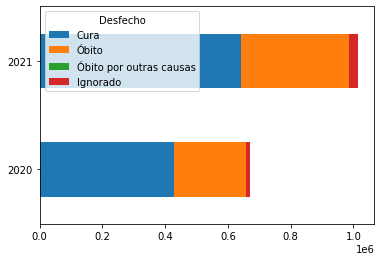

In [11]:
ax = SRAG_balance.plot(
    kind = 'barh',
    stacked = True,
    title = None,
    mark_right = True
)
ax.figure.savefig(f'{RESULTS}/balance/C1-2020-2021.png')

In [12]:
df = pd.DataFrame()
for file in files:
    print(f'[INFO] Opening {file}')
    year = file.split('/')[-1][:-7]
    aux = pd.read_csv(
        file,
        low_memory=False,
        compression='gzip',
        #usecols=[*cols_in_all, 'TP_IDADE'],
    )
    aux = aux[aux['CLASSI_FIN']==5]
    aux['source_year'] = year
    aux['NU_IDADE_N'] = aux.apply(lambda r: cod2age(r['NU_IDADE_N'], r.get('TP_IDADE', None)), axis=1)
    df = pd.concat([df, aux[[*cols_in_all, 'source_year']]], ignore_index=True)
df.to_csv(f'{RAW_DATA}/c1-SRAG.csv.gz', index=False, compression='gzip')
df

[INFO] Opening datas/raw/2020.csv.gz
[INFO] Opening datas/raw/2021.csv.gz


,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,source_year
0,20/03/2020,12,18/03/2020,12,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSPITAL PRESIDENTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
1,25/03/2020,13,17/03/2020,12,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,BP MIRANTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,19/03/2020,12,15/03/2020,12,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSP MUN PIRITUBA JOSE SOARES HUNGRIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
3,24/03/2020,13,23/03/2020,13,RS,002 CRS,1607.0,PORTO ALEGRE,431490,HOSPITAL DE CLINICAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
4,23/03/2020,13,14/03/2020,11,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,HOSP STA MAGGIORE BELA VISTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807424,27/08/2021,34,27/08/2021,34,GO,CENTRO SUL,1781.0,SENADOR CANEDO,522045,HOSPITAL DE ENFRENTAMENTO AO CORONA VIRUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1807425,22/09/2021,38,16/09/2021,37,DF,NaN,NaN,BRASILIA,530010,UPA RECANTO DAS EMAS,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,2021
1807426,06/09/2021,36,31/08/2021,35,SP,GVE X OSASCO,1335.0,BARUERI,350570,HOSPITALIS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1807427,23/09/2021,38,14/09/2021,37,MG,UBERLANDIA,1462.0,UBERLANDIA,317020,UAI TIBERY ANICE DIB JATENE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


In [13]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807429 entries, 0 to 1807428
Data columns (total 155 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    DT_NOTIFIC   1807429 non-null  object 
 1    SEM_NOT      1807429 non-null  int64  
 2    DT_SIN_PRI   1807429 non-null  object 
 3    SEM_PRI      1807429 non-null  int64  
 4    SG_UF_NOT    1807429 non-null  object 
 5    ID_REGIONA   1573190 non-null  object 
 6    CO_REGIONA   1573190 non-null  float64
 7    ID_MUNICIP   1807429 non-null  object 
 8    CO_MUN_NOT   1807429 non-null  int64  
 9    ID_UNIDADE   1807429 non-null  object 
 10   CO_UNI_NOT   1807429 non-null  int64  
 11   CS_SEXO      1807429 non-null  object 
 12   DT_NASC      1805734 non-null  object 
 13   NU_IDADE_N   1807429 non-null  int64  
 14   TP_IDADE     1807429 non-null  int64  
 15   COD_IDADE    1807429 non-null  object 
 16   CS_GESTANT   1807429 non-null  int64  
 17   CS_RACA      1778022 non-

Filtrando os atributos de interesse

In [14]:
symptoms = {
    'FEBRE': 'febre',#
    'TOSSE': 'tosse',#
    'GARGANTA': 'dor de garganta',#
    'DISPNEIA': 'dispneia',#
    'DIARREIA': 'diarréia',#
    'DESC_RESP': 'desconforto respiratório',#
    'SATURACAO': 'saturação baixa',#
    'VOMITO': 'vomito',
    'DOR_ABD': 'dor abdominal',
    'FADIGA': 'fadiga',
    'PERD_OLFT': 'perda do olfato',
    'PERD_PALA': 'perda do paladar',
}

comorbidities = {
    'CARDIOPATI': 'cardiopatia',#
    'PNEUMOPATI': 'pneumopatia',#
    'RENAL': 'doença renal',#
    'IMUNODEPRE': 'imunodepressão',#
    'HEPATICA': 'doença hepática',#
    'NEUROLOGIC': 'doença neurológica',#
    'OBESIDADE': 'obesidade',#
    'PUERPERA': 'puérpera',#
    'SIND_DOWN': 'síndrome de Down',#
    'HEMATOLOGI': 'hematológica',
    'ASMA': 'asma',
    'DIABETES': 'diabetes',
}

interest_cols = {
    **symptoms,
    **comorbidities,
    'FATOR_RISC': 'fatores de risco',
    'CS_SEXO': 'sexo',#
    'NU_IDADE_N': 'idade',#
    'EVOLUCAO': 'desfecho',#
    # 'EVOLUCAO': 'desfecho',#
    'source_year': 'ano fonte',#
    # 'VACINA_COV': 'vacinado',
    'DT_1_DOSE': 'data 1ª dose',
    'DT_2_DOSE': 'data 2ª dose',
}

In [15]:
df = pd.read_csv(f'{RAW_DATA}/c1-SRAG.csv.gz', low_memory=False, compression='gzip', usecols=interest_cols.keys())
df.rename(columns=interest_cols, inplace=True)
df.to_csv(f'{RAW_DATA}/c1-SRAG_filtered.csv.gz', index=False, compression='gzip')
df

,sexo,idade,febre,tosse,dor de garganta,dispneia,desconforto respiratório,saturação baixa,diarréia,vomito,...,doença renal,obesidade,data 1ª dose,data 2ª dose,desfecho,dor abdominal,fadiga,perda do olfato,perda do paladar,ano fonte
0,F,32,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2020
1,M,57,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2020
2,M,79,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2020
3,F,92,1.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,...,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2020
4,F,68,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807424,M,33,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1807425,M,57,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2021
1807426,M,35,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,2021
1807427,F,78,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,...,2.0,2.0,NaN,NaN,NaN,2.0,1.0,2.0,1.0,2021


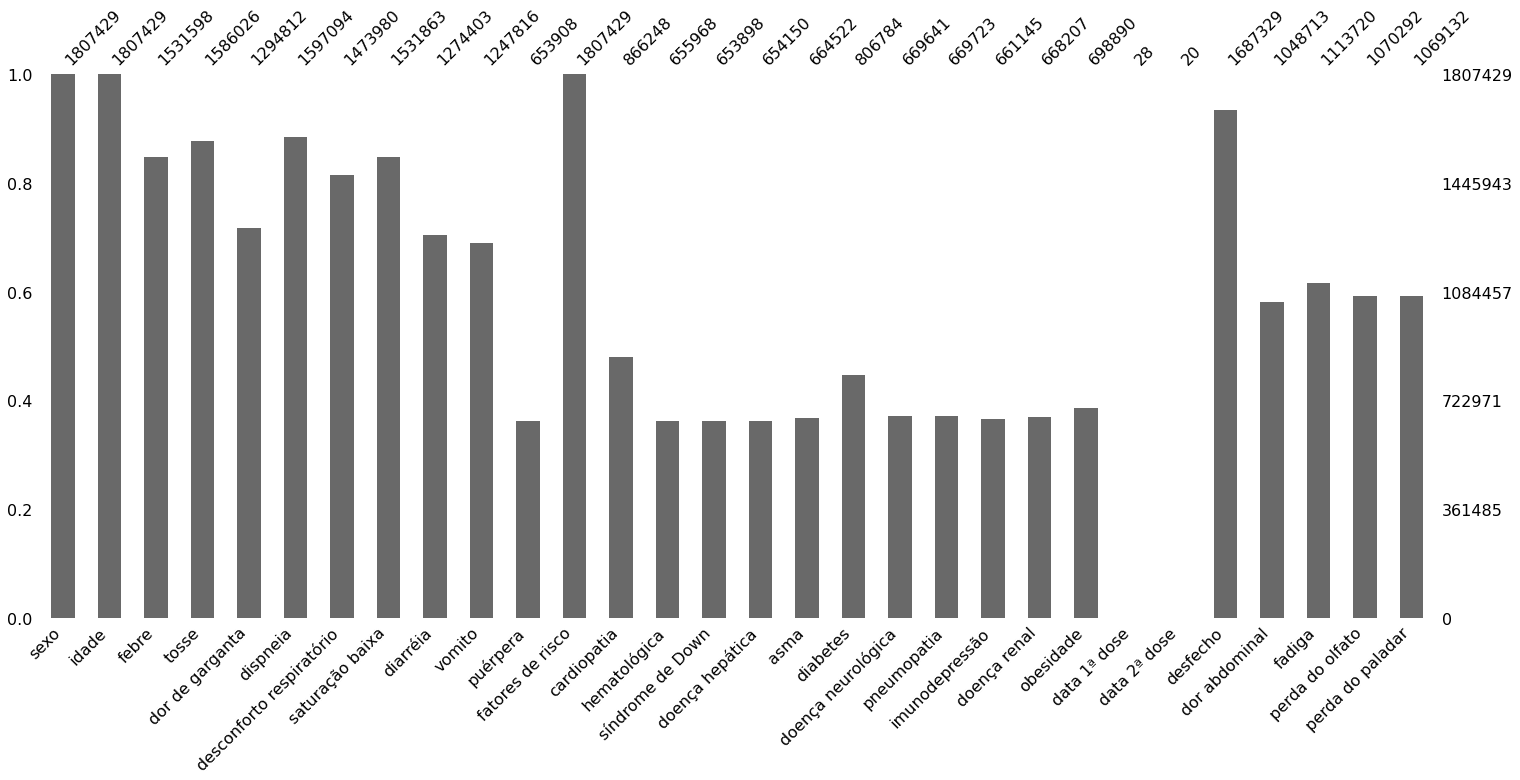

In [16]:
aux = df[[c for c in df.columns if c not in ['ano fonte']]]
fig = msno.bar(aux, labels=True) # fontsize=7
fig_copy = fig.get_figure()
fig_copy.savefig(f'{RESULTS}/missing/c1-bar.png')

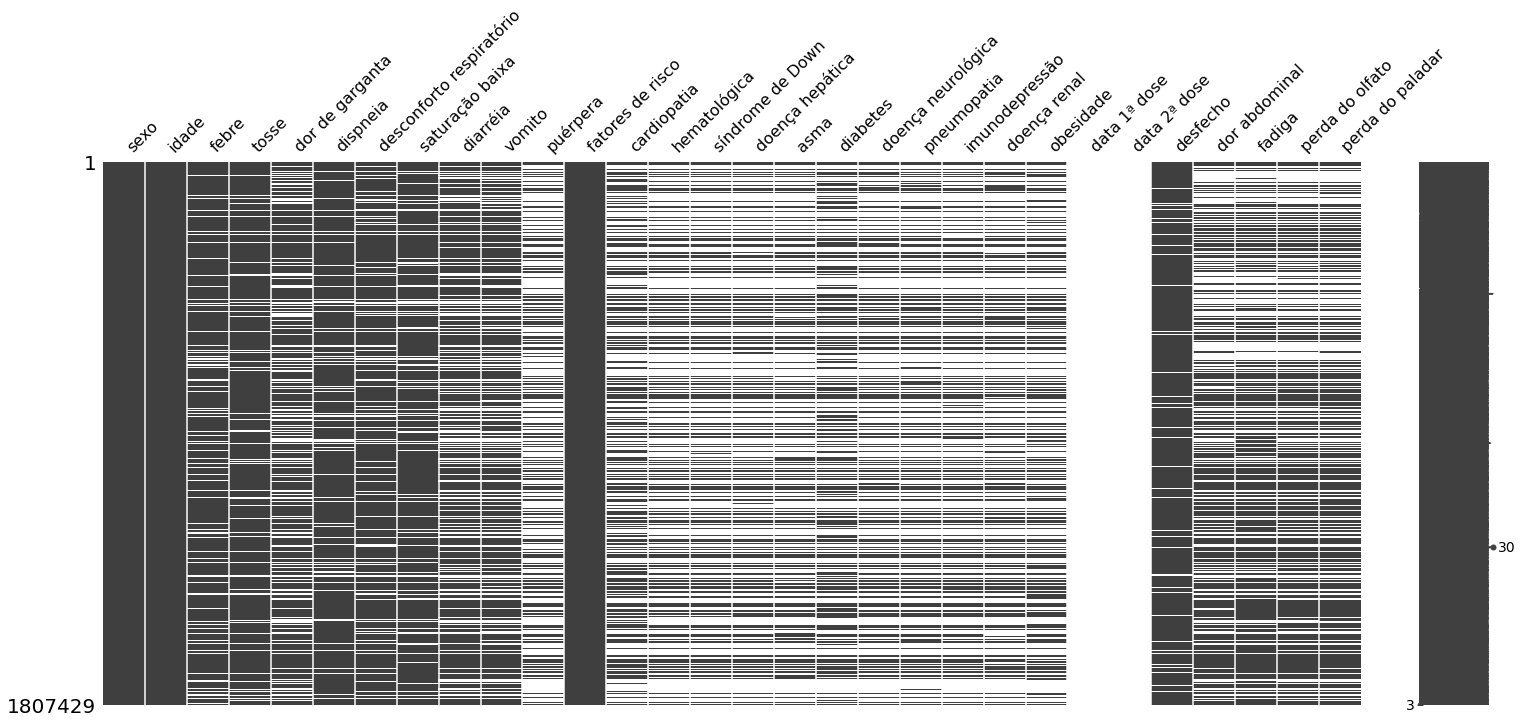

In [17]:
aux = df[[c for c in df.columns if c not in ['ano fonte']]]
fig = msno.matrix(aux) # fontsize=7
fig_copy = fig.get_figure()
fig_copy.savefig(f'{RESULTS}/missing/c1-matrix.png')

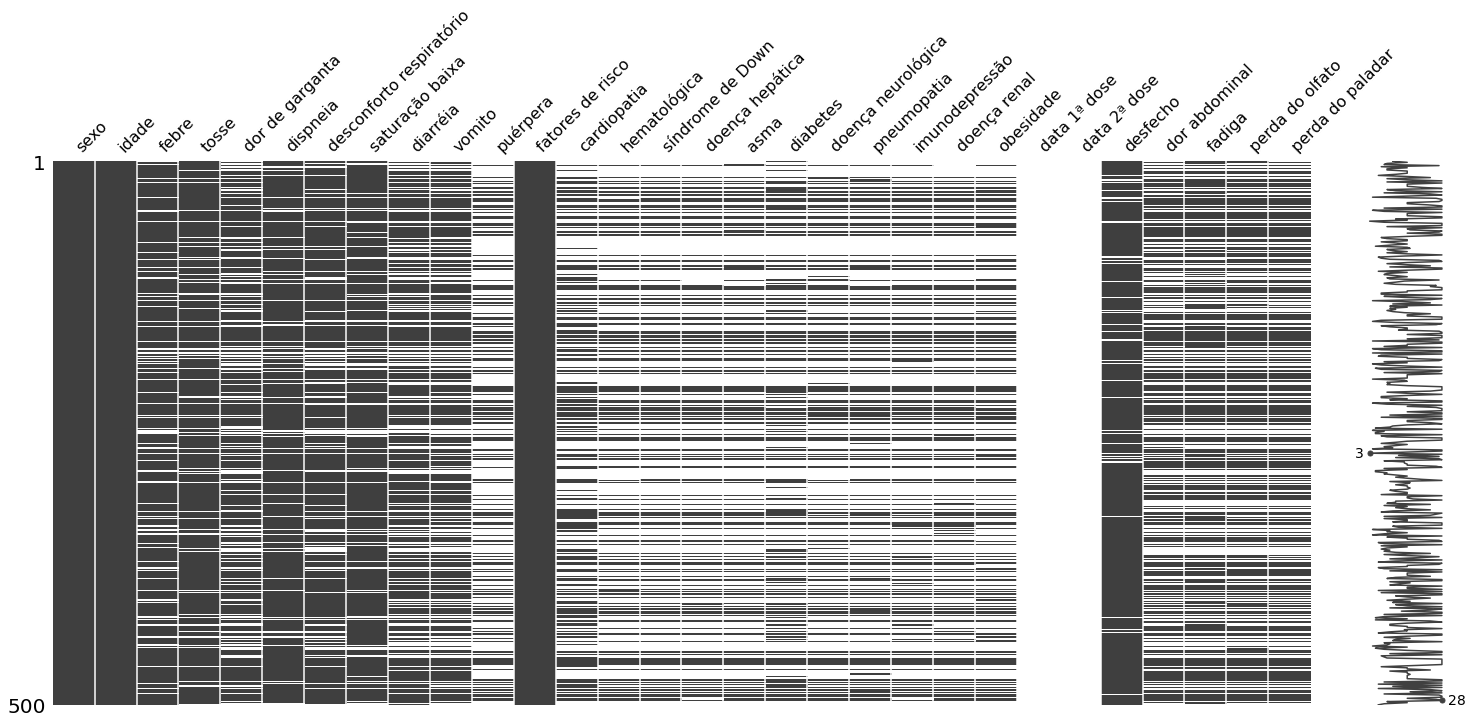

In [18]:
aux = df[[c for c in df.columns if c not in ['ano fonte']]].sample(500)
fig = msno.matrix(aux) # fontsize=7
fig_copy = fig.get_figure()
fig_copy.savefig(f'{RESULTS}/missing/c1-matrix-sm.png')

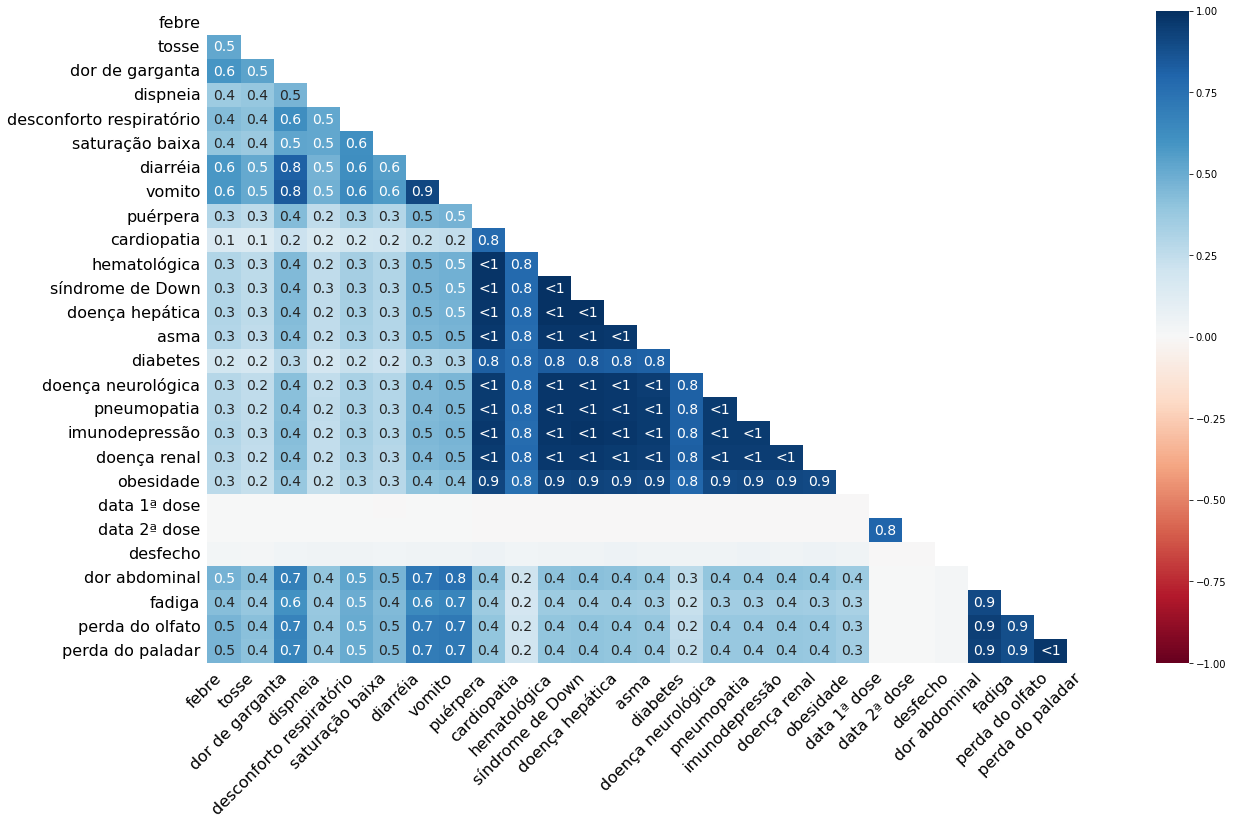

In [19]:
aux = df[[c for c in df.columns if c not in ['ano fonte']]]
fig = msno.heatmap(aux, labels=True) # fontsize=7
fig_copy = fig.get_figure()
fig_copy.savefig(f'{RESULTS}/missing/c1-heatmap.png')

In [20]:
aux = df.copy()
aux.dropna()

,sexo,idade,febre,tosse,dor de garganta,dispneia,desconforto respiratório,saturação baixa,diarréia,vomito,...,doença renal,obesidade,data 1ª dose,data 2ª dose,desfecho,dor abdominal,fadiga,perda do olfato,perda do paladar,ano fonte
438891,F,5,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,...,2.0,2.0,26/05/2019,13/05/2020,1.0,2.0,2.0,2.0,2.0,2020
1282323,M,1,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,2.0,1.0,27/05/2020,05/08/2020,1.0,2.0,2.0,2.0,2.0,2021


Reclassificação

In [21]:
missing = df.isnull().mean() * 100
missing

sexo                         0.000000
idade                        0.000000
febre                       15.260959
tosse                       12.249610
dor de garganta             28.361667
dispneia                    11.637248
desconforto respiratório    18.448802
saturação baixa             15.246297
diarréia                    29.490840
vomito                      30.961825
puérpera                    63.821096
fatores de risco             0.000000
cardiopatia                 52.072917
hematológica                63.707122
síndrome de Down            63.821649
doença hepática             63.807707
asma                        63.233853
diabetes                    55.362894
doença neurológica          62.950633
pneumopatia                 62.946096
imunodepressão              63.420693
doença renal                63.029972
obesidade                   61.332368
data 1ª dose                99.998451
data 2ª dose                99.998893
desfecho                     6.644798
dor abdomina

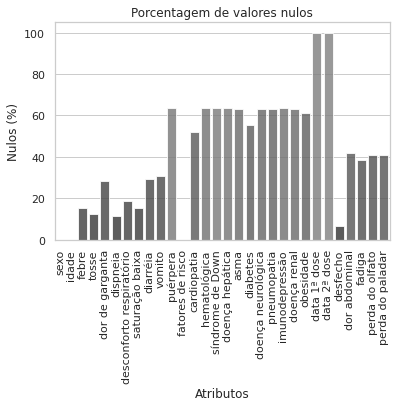

In [22]:
sns.set(style="whitegrid", color_codes=True)
# pal = sns.color_palette("Greens_d", len(missing))
# pal = sns.color_palette("ch:s=0,rot=0", len(missing))
pal = sns.color_palette("dark:grey_r", len(missing))
rank = missing.argsort().argsort()

plt.figure()
# splot = sns.barplot(x=missing.index[:-1], y=missing.values[:-1], palette=pal, alpha=0.8)
splot = sns.barplot(x=missing.index[:-1], y=missing.values[:-1], palette=np.array(pal[::-1])[rank], alpha=0.8)
plt.title('Porcentagem de valores nulos')
plt.ylabel('Nulos (%)', fontsize=12)
plt.xlabel('Atributos', fontsize=12)
plt.xticks(rotation=90)

fig = splot.get_figure()
fig.savefig(f'{RESULTS}/missing/c1-percent.png')
plt.show()

In [23]:
missing[missing > 50]

puérpera              63.821096
cardiopatia           52.072917
hematológica          63.707122
síndrome de Down      63.821649
doença hepática       63.807707
asma                  63.233853
diabetes              55.362894
doença neurológica    62.950633
pneumopatia           62.946096
imunodepressão        63.420693
doença renal          63.029972
obesidade             61.332368
data 1ª dose          99.998451
data 2ª dose          99.998893
dtype: float64

In [24]:
df = pd.read_csv(f'{RAW_DATA}/c1-SRAG_filtered.csv.gz', low_memory=False, compression='gzip')
df = df.drop(columns=missing[missing > 50].index)
df.to_csv(f'{RAW_DATA}/c1-SRAG_filtered_nans.csv.gz', index=False, compression='gzip')
df

,sexo,idade,febre,tosse,dor de garganta,dispneia,desconforto respiratório,saturação baixa,diarréia,vomito,fatores de risco,desfecho,dor abdominal,fadiga,perda do olfato,perda do paladar,ano fonte
0,F,32,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,N,1.0,NaN,NaN,NaN,NaN,2020
1,M,57,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,N,1.0,NaN,NaN,NaN,NaN,2020
2,M,79,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,S,2.0,NaN,NaN,NaN,NaN,2020
3,F,92,1.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,S,2.0,NaN,NaN,NaN,NaN,2020
4,F,68,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,S,1.0,NaN,NaN,NaN,NaN,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807424,M,33,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2021
1807425,M,57,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2,NaN,2.0,2.0,2.0,2.0,2021
1807426,M,35,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2,NaN,2.0,1.0,2.0,2.0,2021
1807427,F,78,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1,NaN,2.0,1.0,2.0,1.0,2021


|sintomas|comorbidades|sexo|SRAG|desfecho|
|--|--|--|--|--|
|1. Sim|1. Sim|F: Feminino|1. SRAG por influenza|1. Cura|
|2. Não|2. Não|M: Masculino|2. SRAG por outro vírus respiratório|2: Óbito|
|9. Ignorado|9. Ignorado||3. SRAG por outro agente Etiológico|3: Óbito por outras causas|
||||4. SRAG não especificado|9: Ignorado|
||||5. COVID-19||

In [35]:
df = pd.read_csv(f'{RAW_DATA}/c1-SRAG_filtered_nans.csv.gz', low_memory=False, compression='gzip')

rules = []
rules.append({'cols': 'desfecho', 'replaces': {1: 1, 2: 0, 3: np.nan, 9: np.nan}})
rules.append({'cols': 'sexo', 'replaces': {'M': 1, 'F': 2, 'I': 9}})
rules.append({'cols': 'fatores de risco', 'replaces': {'S': 1, 'N': 2, 'I': 9}})

df = clean(df, rules)
df = df[df['desfecho'].isin([0,1])]
df.to_csv(f'{RAW_DATA}/c1-SRAG_clean.csv.gz', index=False, compression='gzip')
df

,sexo,idade,febre,tosse,dor de garganta,dispneia,desconforto respiratório,saturação baixa,diarréia,vomito,fatores de risco,desfecho,dor abdominal,fadiga,perda do olfato,perda do paladar,ano fonte
0,2,32,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2,1.0,NaN,NaN,NaN,NaN,2020
1,1,57,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2,1.0,NaN,NaN,NaN,NaN,2020
2,1,79,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,0.0,NaN,NaN,NaN,NaN,2020
3,2,92,1.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,1,0.0,NaN,NaN,NaN,NaN,2020
4,2,68,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807419,1,58,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2021
1807420,1,56,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2,1.0,2.0,1.0,2.0,2.0,2021
1807422,2,97,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,0.0,2.0,2.0,2.0,2.0,2021
1807423,2,73,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2,1.0,2.0,2.0,2.0,2.0,2021


Balanceamento

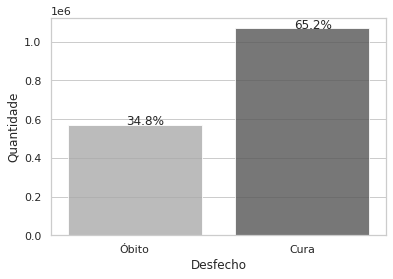

In [36]:
def without_hue(plot, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()


df_class = df.groupby('desfecho').size()
df_class.rename({
    0.0: 'Óbito',
    1.0: 'Cura',
}, inplace=True)
#df_class.plot(kind='barh')
ax = sns.barplot(x=df_class.index, y=df_class.values, palette="gray_r", alpha=0.8)
# plt.title('Balanço das classes')
# plt.yticks(size=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Desfecho', fontsize=12)

fig = splot.get_figure()
fig.savefig(f'{RESULTS}/balance/c1-general.png')

without_hue(ax, len(df))
# plt.show()

In [37]:
missing = df.isnull().mean() * 100
missing

sexo                         0.000000
idade                        0.000000
febre                       14.834924
tosse                       11.929037
dor de garganta             27.677989
dispneia                    11.121365
desconforto respiratório    17.817320
saturação baixa             14.715774
diarréia                    28.695025
vomito                      30.155827
fatores de risco             0.000000
desfecho                     0.000000
dor abdominal               41.521582
fadiga                      37.993997
perda do olfato             40.388930
perda do paladar            40.457581
ano fonte                    0.000000
dtype: float64

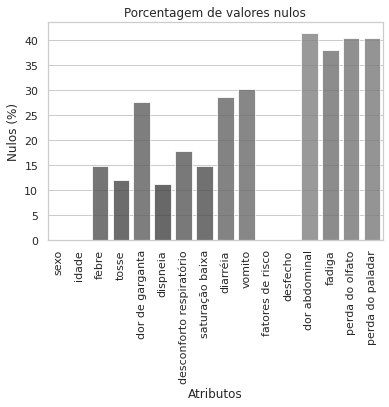

In [38]:
sns.set(style="whitegrid", color_codes=True)
# pal = sns.color_palette("Greens_d", len(missing))
pal = sns.color_palette("dark:grey_r", len(missing))
rank = missing.argsort().argsort()

plt.figure()
splot = sns.barplot(x=missing.index[:-1], y=missing.values[:-1], palette=np.array(pal[::-1])[rank], alpha=0.8)
plt.title('Porcentagem de valores nulos')
plt.ylabel('Nulos (%)', fontsize=12)
plt.xlabel('Atributos', fontsize=12)
plt.xticks(rotation=90)

fig = splot.get_figure()
fig.savefig(f'{RESULTS}/missing/c1-percent_after_clean.png')
plt.show()

In [39]:
sc_cols = set([*symptoms.values(), *comorbidities.values()])
cols = set(df.columns)
it_cols = list(cols.intersection(sc_cols))

In [40]:
df = pd.read_csv(f'{RAW_DATA}/c1-SRAG_clean.csv.gz', low_memory=False, compression='gzip')

rules = []
rules.append({'cols': it_cols, 'replaces': {np.nan: 0.}})

df = clean(df, rules)
df.to_csv(f'{PROCESSED_DATA}/c1-SRAG.csv.gz', index=False, compression='gzip')
df

,sexo,idade,febre,tosse,dor de garganta,dispneia,desconforto respiratório,saturação baixa,diarréia,vomito,fatores de risco,desfecho,dor abdominal,fadiga,perda do olfato,perda do paladar,ano fonte
0,2,32,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2,1.0,0.0,0.0,0.0,0.0,2020
1,1,57,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2,1.0,0.0,0.0,0.0,0.0,2020
2,1,79,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,0.0,0.0,0.0,0.0,0.0,2020
3,2,92,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,2020
4,2,68,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641628,1,58,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2021
1641629,1,56,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2,1.0,2.0,1.0,2.0,2.0,2021
1641630,2,97,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,0.0,2.0,2.0,2.0,2.0,2021
1641631,2,73,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2,1.0,2.0,2.0,2.0,2.0,2021


In [41]:
missing = df.isnull().mean() * 100
missing

sexo                        0.0
idade                       0.0
febre                       0.0
tosse                       0.0
dor de garganta             0.0
dispneia                    0.0
desconforto respiratório    0.0
saturação baixa             0.0
diarréia                    0.0
vomito                      0.0
fatores de risco            0.0
desfecho                    0.0
dor abdominal               0.0
fadiga                      0.0
perda do olfato             0.0
perda do paladar            0.0
ano fonte                   0.0
dtype: float64